In [1]:
#!/usr/local/lib/anaconda3/bin/python
# -*- coding: utf-8 -*-
import sys
import logging
from logging.config import fileConfig
import numpy as np
from matplotlib import pyplot as plt
from numpy import random
import numpy.linalg as la
import scipy.optimize as spo

### experiment design2 (Zupanski et al. 2008)

1.$ dx = 0.05, dt = 0.0125(= 45 sec), \nu = 0.05 $

2.number of points = 81, member = 4, number of observations = 81(all)

3.number of DA cycles = 20, interval between cycles = 15 minutes(= every 20 steps)

4-1.quadratic obs
$ H(x) = x^2 (x \ge 0.5) , -x^2 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 8.0e-2, obs PDF = Gaussian

4-2.cubic obs
$ H(x) = x^3 (x \ge 0.5) , -x^3 (x \lt 0.5) $

obs mean = 0.0, obs stdv = 7.0e-4, obs PDF = Gaussian

5.initial state = begin forecast 2 cycles before TRUE

6.ensemble perturbation = lagged forecast (lag interval = ?)


In [2]:
# BURGERS MODEL
def l_operator(f, u, dx, nu):
# NB u is defined at integral index
# u[i-1/2] = (u[i-1] + u[i]) / 2
# u[i+1/2] = (u[i] + u[i+1]) / 2
# u[i+1/2] - u[i-1/2] = (u[i+1] - u[i-1]) / 2
    l = np.zeros_like(u)
    l[1:-1] = -0.5 * (f[2:] - f[0:-2]) / dx \
        + nu / dx**2 * (u[2:] - 2 * u[1:-1] + u[0:-2])
    return l


def step(u, dx, dt, nu):
    f = 0.5 * u**2
    u1 = u + dt * l_operator(f, u, dx, nu)
    return 0.5 * (u + u1 + dt * l_operator(f, u1, dx, nu))

In [3]:
#logging.config.fileConfig("logging_config.ini")
#logger = logging.getLogger(__name__)


def precondition(zmat):
    u, s, vt = la.svd(zmat)
    v = vt.transpose()
    is2r = 1 / (1 + s**2)
    tmat = v @ np.diag(np.sqrt(is2r)) @ vt
    heinv = v @ np.diag(is2r) @ vt
#    logger.debug("tmat={}".format(tmat))
#    logger.debug("heinv={}".format(heinv))
#    logger.debug("s={}".format(s))
    return tmat, heinv


zetak = []
def callback(xk):
    global zetak
#    logger.debug("xk={}".format(xk))
    zetak.append(xk)


def calc_j(zeta, *args):
    xc, pf, y, tmat, gmat, heinv, rinv, htype = args
    x = xc + gmat @ zeta
    ob = y - h_operator(x, htype["operator"])
    j = 0.5 * (zeta.transpose() @ heinv @ zeta + ob.transpose() @ rinv @ ob)
#    logger.debug("zeta.shape={}".format(zeta.shape))
#    logger.debug("j={} zeta={}".format(j, zeta))
    return j
    

def calc_grad_j(zeta, *args):
    xc, pf, y, tmat, gmat, heinv, rinv, htype = args
    x = xc + gmat @ zeta
    hx = h_operator(x, htype["operator"])
    ob = y - hx
    if htype["perturbation"] == "grad":
        dh = dhdx(x, htype["operator"]) @ pf
    else:
        dh = h_operator(x[:, None] + pf, htype["operator"]) - hx[:, None]
    return tmat @ zeta - dh.transpose() @ rinv @ ob


def analysis(xf, xc, y, rmat, rinv, htype, gtol=1e-8, 
        disp=False, save_hist=False, save_dh=False):
    global zetak
    op = htype["operator"]
    pt = htype["perturbation"]
    pf = xf - xc[:, None]
#    logger.debug("norm(pf)={}".format(la.norm(pf)))
    if pt == "grad":
#        logger.debug("dhdx.shape={}".format(obs.dhdx(xc, op).shape))
        dh = dhdx(xc, op) @ pf
    else:
        dh = h_operator(xf, op) - h_operator(xc, op)[:, None]
    if save_dh:
        np.save("dh_{}_{}.npy".format(op, pt), dh)
#    logger.info("save_dh={}".format(save_dh))
    zmat = rmat @ dh
#    logger.debug("cond(zmat)={}".format(la.cond(zmat)))
    tmat, heinv = precondition(zmat)
#    logger.debug("pf.shape={}".format(pf.shape))
#    logger.debug("tmat.shape={}".format(tmat.shape))
#    logger.debug("heinv.shape={}".format(heinv.shape))
    gmat = pf @ tmat
#    logger.debug("gmat.shape={}".format(gmat.shape))
    x0 = np.zeros(xf.shape[1])
    args_j = (xc, pf, y, tmat, gmat, heinv, rinv, htype)
#    logger.info("save_hist={}".format(save_hist))
    if save_hist:
        res = spo.minimize(calc_j, x0, args=args_j, method='BFGS', \
                jac=calc_grad_j, options={'gtol':gtol, 'disp':disp}, callback=callback)
        jh = np.zeros(len(zetak))
        gh = np.zeros(len(zetak))
        for i in range(len(zetak)):
            jh[i] = calc_j(np.array(zetak[i]), *args_j)
            g = calc_grad_j(np.array(zetak[i]), *args_j)
            gh[i] = np.sqrt(g.transpose() @ g)
        np.savetxt("jh_{}_{}.txt".format(op, pt), jh)
        np.savetxt("gh_{}_{}.txt".format(op, pt), gh)
    else:
        res = spo.minimize(calc_j, x0, args=args_j, method='BFGS', \
                jac=calc_grad_j, options={'gtol':gtol, 'disp':disp})
#    logger.info("success={} message={}".format(res.success, res.message))
#    logger.info("J={:7.3e} dJ={:7.3e} nit={}".format( \
#            res.fun, np.sqrt(res.jac.transpose() @ res.jac), res.nit))
    xa = xc + gmat @ res.x
    if pt == "grad":
        dh = dhdx(xa, op) @ pf
    else:
        dh = h_operator(xa[:, None] + pf, op) - h_operator(xa, op)[:, None]
    zmat = rmat @ dh
#    logger.debug("cond(zmat)={}".format(la.cond(zmat)))
    tmat, heinv = precondition(zmat)
    pa = pf @ tmat 
    return xa, pa


In [4]:
def h_operator(x, operator="linear"):
    if operator == "linear":
        return x
    elif operator == "quadratic":
        return x**2
    elif operator == "cubic":
        return x**3
    elif operator == "quadratic-nodiff":
        return np.where(x >= 0.5, x**2, -x**2)
    elif operator == "cubic-nodiff":
        return np.where(x >= 0.5, x**3, -x**3)

def dhdx(x, operator="linear"):
    if operator == "linear":
        return np.diag(np.ones(x.size))
    elif operator == "quadratic":
        return np.diag(2 * x)
    elif operator == "cubic":
        return np.diag(3 * x**2)
    elif operator == "quadratic-nodiff":
        return np.diag(np.where(x >= 0.5, 2*x, -2*x))
    elif operator == "cubic-nodiff":
        return np.diag(np.where(x >= 0.5, 3*x**2, -3*x**2))

In [5]:
def initialize(opt):
    global u0, x, jmax, xmax, dx, dt, nu, dt_sec, obs_m, obs_s, obs_opt, obstype
    
    jmax = 81
    xmax = 2.0
    dx = 0.05
    dt = 0.0125
    dt_sec = dt*3600.0
    nu = 0.05
    x = np.arange(jmax)*dx - xmax
    u0 = np.zeros(jmax)
    u0[0] = 1.0
    dum = np.zeros(jmax)
    obs_opt = opt
    
    obs_m = 0.0
    if(opt==0): # y=x
        obs_s = 1.0e-1
    elif(opt==1 or opt==3): # y=x^2
        obs_s = 8.0e-2
    elif(opt==2 or opt==4): # y=x^3
        obs_s = 7.0e-4
    
    # initial state
    for k in range(40):
        dum = step(u0, dx, dt, nu)
        u0 = dum[:]
    plt.plot(x,u0)
    plt.title("initial state")
    plt.show()
    print("nx={} nu={} dx={:7.3e} dt={:7.3e} dt_sec={:7.3e}".format(jmax, nu, dx, dt, dt_sec))
    obstype = ['linear','quadratic','cubic','quadratic-nodiff','cubic-nodiff']
    print(obstype[obs_opt])

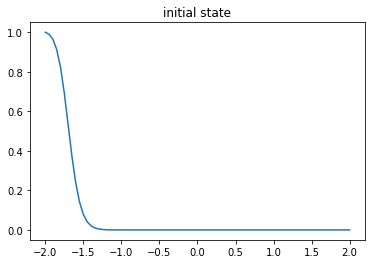

nx=81 nu=0.05 dx=5.000e-02 dt=1.250e-02 dt_sec=4.500e+01
cubic-nodiff
Number of DA cycles = 20cycles, cycle interval = 15.0min., each cycle steps = 20steps
Number of observations = 81, observation option = 4
fcst length = 400, incr_dt = 900.0sec.
[1.00000000e+00 9.89551766e-01 9.64332152e-01 9.12943022e-01
 8.23325101e-01 6.91853561e-01 5.32260231e-01 3.72328806e-01
 2.38035879e-01 1.40890357e-01 7.83472428e-02 4.14353201e-02
 2.10152930e-02 1.02718782e-02 4.85097001e-03 2.21608022e-03
 9.79758666e-04 4.19259099e-04 1.73649699e-04 6.96116177e-05
 2.70085830e-05 1.01424872e-05 3.68666563e-06 1.29719399e-06
 4.41876940e-07 1.45737479e-07 4.65441501e-08 1.43957113e-08
 4.31244332e-09 1.25135399e-09 3.51756866e-10 9.57951224e-11
 2.52759881e-11 6.46181058e-12 1.60062718e-12 3.84162579e-13
 8.93341931e-14 2.01268732e-14 4.39296400e-15 9.28788040e-16
 1.90193457e-16 3.77158299e-17 7.24129363e-18 1.34577859e-18
 2.42036625e-19 4.21121240e-20 7.08602738e-21 1.15265789e-21
 1.81180797e-22 2.750

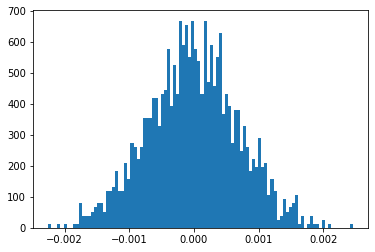

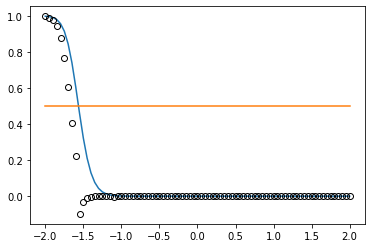

obs mean=-2.5921752711450103e-05, obs stdv=4.5684772875005496e-07


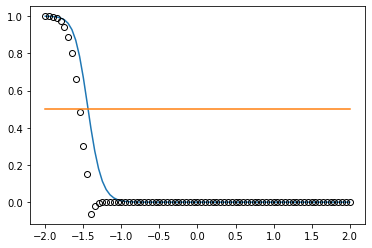

obs mean=4.041093966237875e-05, obs stdv=5.596915429810898e-07


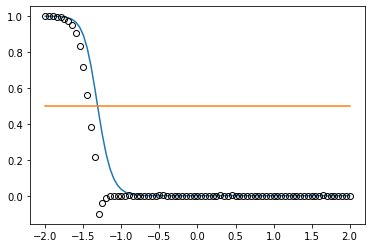

obs mean=6.0781635392611674e-05, obs stdv=5.240170569284128e-07


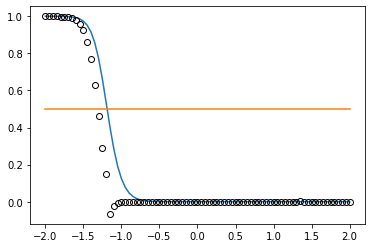

obs mean=-5.682980401121737e-05, obs stdv=3.9252351899377873e-07


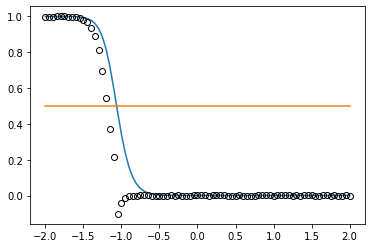

obs mean=-3.426584415615915e-05, obs stdv=5.483142895088094e-07


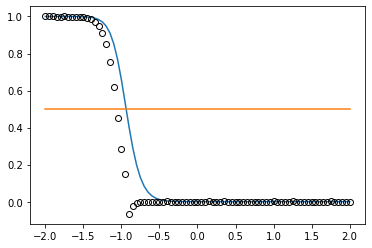

obs mean=-9.465010310081774e-05, obs stdv=4.5860029878034224e-07


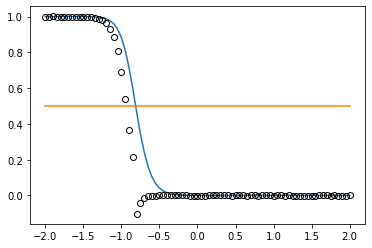

obs mean=4.950348687197043e-05, obs stdv=4.861744021087467e-07


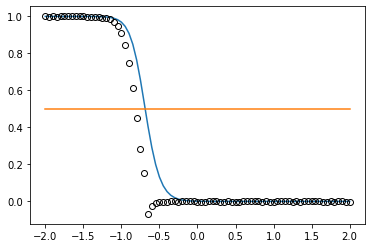

obs mean=-0.00015180691650879108, obs stdv=4.4233778034668526e-07


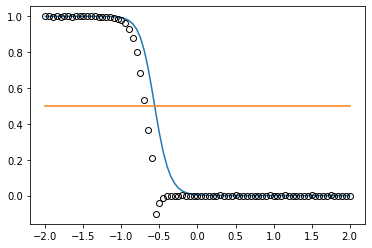

obs mean=-6.723954624909818e-05, obs stdv=4.577388572457246e-07


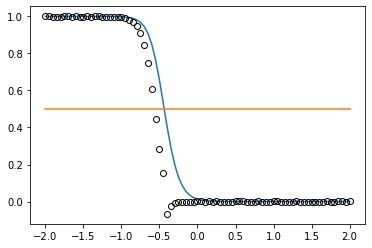

obs mean=-0.00010693213282440883, obs stdv=6.81491743650418e-07


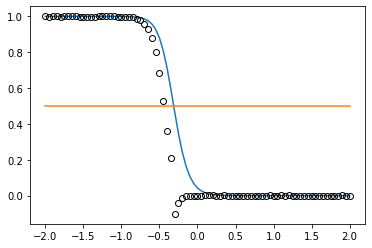

obs mean=1.6709959171971035e-05, obs stdv=4.2559897321735213e-07


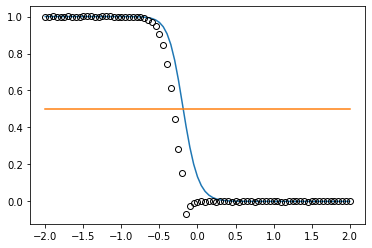

obs mean=1.0269824044008139e-05, obs stdv=6.44595029361754e-07


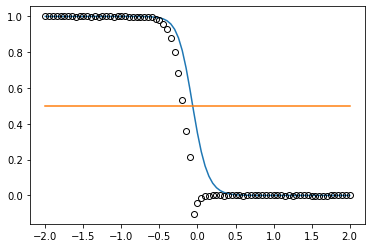

obs mean=0.00013884623759252332, obs stdv=4.952601891318018e-07


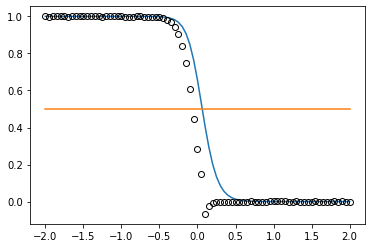

obs mean=2.1607763745945276e-05, obs stdv=3.5934165251754803e-07


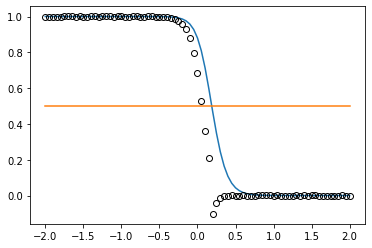

obs mean=7.020176496701376e-06, obs stdv=4.1505890648780385e-07


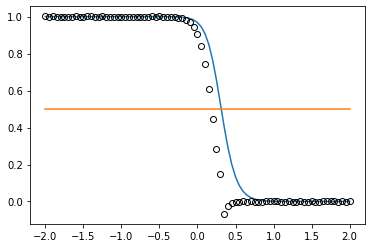

obs mean=6.374010593136571e-05, obs stdv=4.799612576907321e-07


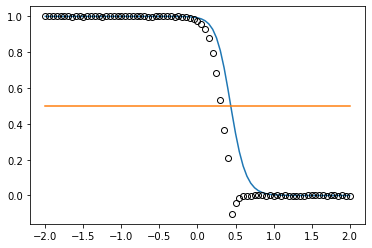

obs mean=-9.665662615611902e-05, obs stdv=4.776730552754617e-07


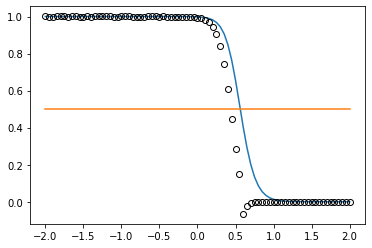

obs mean=5.2622619053178665e-05, obs stdv=4.087395960618975e-07


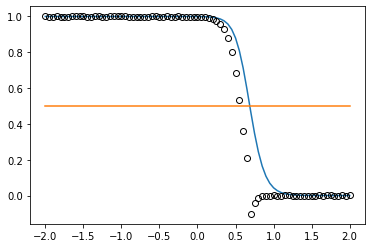

obs mean=-6.946502623321142e-05, obs stdv=4.942993911972801e-07


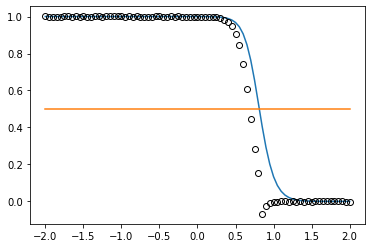

obs mean=2.4310420339010722e-05, obs stdv=4.881417039383211e-07


In [17]:
### true state and obs
initialize(opt=4)
N_cycles = 20
cycle_int = 15.0 #minutes
N_steps = int(cycle_int * 60. / dt_sec)
N_obs = jmax
print("Number of DA cycles = {}cycles, cycle interval = {}min., each cycle steps = {}steps"
      .format(N_cycles, cycle_int, N_steps))
print("Number of observations = {}, observation option = {}".format(N_obs, obs_opt))

yo = np.zeros((N_cycles,N_obs)) # observation
mask = np.random.choice(jmax,jmax-N_obs,replace=False) # obsmiss

## true
fcst_length = N_steps * N_cycles
incr_dt = cycle_int * 60.
print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
ut = np.zeros((fcst_length+1,jmax))
# initialize
ut[0] = u0[:]

#plt.plot(x,ut[0])
print(ut[0])
line = np.ones(x.size)*0.5
i = 0
for k in range(1,fcst_length+1):
    ut[k] = step(ut[k-1], dx, dt, nu)
    if (k%N_steps==0):
        yo[i] = h_operator(ut[k],operator=obstype[obs_opt])
        i += 1
        print("cycle{}".format(int(k/N_steps)))
        #print(ut[k])
#plt.title("true state")
#plt.show()

## observation
#obs_m = obs_m3
#obs_s = obs_s3
print(obs_m, obs_s)
#err = [random.normalvariate(obs_m, obs_s) for k in range(yo.size)]
#oberr = np.array(err).reshape(yo.shape)
oberr = random.normal(obs_m, scale=obs_s, size=yo.size)
plt.hist(oberr,bins=100,density=True)
plt.show()
yo += oberr.reshape(yo.shape)
for k in range(N_cycles):
    d = yo[k] - h_operator(ut[int((k+1)*N_steps)],obstype[obs_opt])
    plt.plot(x,ut[int((k+1)*N_steps)])
    plt.plot(x,yo[k],"ko",markerfacecolor="none")
    plt.plot(x,line)
    plt.show()
        
    #print(d)
    print("obs mean={}, obs stdv={}".format(np.mean(d), np.mean((d - np.mean(d))**2)))

fcst length = 440, incr_dt = 900.0sec.
cycle1
[1.00000000e+00 9.99908672e-01 9.99678314e-01 9.99157250e-01
 9.98051136e-01 9.95805034e-01 9.91400100e-01 9.83026413e-01
 9.67619580e-01 9.40383346e-01 8.94776989e-01 8.23951650e-01
 7.24436924e-01 6.00695742e-01 4.66282606e-01 3.38772611e-01
 2.31882720e-01 1.51101835e-01 9.47838206e-02 5.77806019e-02
 3.44713147e-02 2.02200479e-02 1.16944707e-02 6.67926742e-03
 3.77007931e-03 2.10356506e-03 1.16020226e-03 6.32422591e-04
 3.40619995e-04 1.81219503e-04 9.52129056e-05 4.93894301e-05
 2.52883700e-05 1.27781734e-05 6.37091153e-06 3.13367352e-06
 1.52044191e-06 7.27618146e-07 3.43413036e-07 1.59837608e-07
 7.33611398e-08 3.32016670e-08 1.48165608e-08 6.51958794e-09
 2.82861351e-09 1.21005966e-09 5.10412945e-10 2.12286778e-10
 8.70597634e-11 3.52057942e-11 1.40385885e-11 5.52023136e-12
 2.14056655e-12 8.18562506e-13 3.08703424e-13 1.14818792e-13
 4.21194169e-14 1.52393288e-14 5.43850998e-15 1.91443770e-15
 6.64762339e-16 2.27704719e-16 7.694396

cycle17
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 9.99999999e-01 9.99999999e-01 9.99999998e-01
 9.99999996e-01 9.99999993e-01 9.99999988e-01 9.99999978e-01
 9.99999961e-01 9.99999929e-01 9.99999872e-01 9.99999770e-01
 9.99999586e-01 9.99999258e-01 9.99998670e-01 9.99997618e-01
 9.99995738e-01 9.99992378e-01 9.99986377e-01 9.99975663e-01
 9.99956541e-01 9.99922422e-01 9.99861564e-01 9.99753042e-01
 9.99559591e-01 9.99214906e-01 9.98601181e-01 9.97509653e-01
 9.95572061e-01 9.92144022e-01 9.86114048e-01 9.75613014e-01
 9.57635567e-01 9.27717756e-01 8.80110081e-01 8.09212332e-01
 7.12712231e-01 5.95101499e-01 4.68292497e-01 3.47419008e-01
 2.44521790e-01 1.64888132e-01 1.07673463e-01 6.87377959e-02
 4.32182665e-02 2.69047094e-02 1.66431958e-02 1.02543216e-02
 6.30206224e-03 

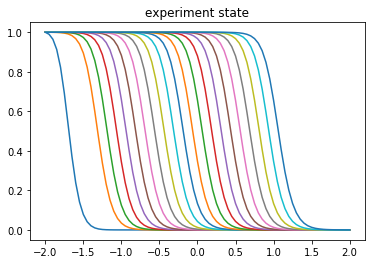

rmse no-obs
[0.16788967 0.16248934 0.15956811 0.15784898 0.15678619 0.15610811
 0.1556661  0.15537353 0.15517768 0.15504544 0.15495555 0.15489411
 0.15485193 0.15482286 0.15480277 0.15478885 0.15477917 0.15477244
 0.15476774 0.15476446 0.15476215]


In [7]:
### No-observation experiment
N_cycle_shift = 2 #initial condition lag
fcst_length = N_steps * ( N_cycles + N_cycle_shift )
incr_dt = cycle_int * 60.

print("fcst length = {}, incr_dt = {}sec.".format(fcst_length, incr_dt))
un = np.zeros((fcst_length+1,jmax))
# initialize
un[0] = u0[:]
plt.plot(x,un[0])
for k in range(1,fcst_length+1):
    un[k] = step(un[k-1], dx, dt, nu)
    if (k/N_steps>N_cycle_shift and k%N_steps==0):
        plt.plot(x,un[k])
        print("cycle{}".format(int(k/N_steps-N_cycle_shift)))
        print(un[k])
plt.title("experiment state")
plt.show()

rmsen = np.zeros(N_cycles+1)
for i in range(N_cycles+1):
    ind_n = (i+N_cycle_shift)*N_steps
    ind_t = i*N_steps
    rmsen[i] = np.mean((un[ind_n]-ut[ind_t])**2)
rmsen = np.sqrt(rmsen)
print("rmse no-obs")
print(rmsen)

In [8]:
### ensemble initialize
def init_ens(lag):
    global mem, uc0, ue0, sqrtPa0, ispr
    mem = 4 # ensemble size
    #lag = 15#int(N_steps/2)

    ## control
    t_cntrl = N_cycle_shift * N_steps
    uc0 = np.zeros(jmax)
    uc0 = un[t_cntrl,:]
    #plt.plot(x,uc0)
    ue0 = np.zeros((jmax,mem))
    for imem in range(int(mem/2)):
        t_mem = t_cntrl - lag*(imem+1)
        ue0[:,2*imem] = un[t_mem,:]
        t_mem = t_cntrl + lag*(imem+1)
        ue0[:,2*imem+1] = un[t_mem,:]
    #for imem in range(mem):
    #    plt.plot(x,ue0[:,imem])
    #plt.title("ensemble state")
    #plt.show()
    sqrtPa0 = (ue0 - uc0.reshape(-1,1))#/np.sqrt(2.0*(mem-1))
    P0 = sqrtPa0@sqrtPa0.T/np.sqrt(mem-1)
    ispr = np.mean(np.diag(P0))
    print("initial ensemble spread = {}".format(ispr))
    print("ensemble initialized")
    #print(sqrtPa0)

fcst length = 400, incr_dt = 900.0sec., obs miss = 0
initial ensemble spread = 0.006696762497818081
ensemble initialized
cycle0
cycle1
cycle2
cycle3
Optimization terminated successfully.
         Current function value: 350984.381999
         Iterations: 7
         Function evaluations: 11
         Gradient evaluations: 11
cycle4
cycle5
cycle6
cycle7
cycle8
cycle9
cycle10
cycle11
cycle12
cycle13
cycle14
cycle15
cycle16
cycle17
cycle18
cycle19
initial ensemble spread = 0.006696762497818081
ensemble initialized
cycle0
cycle1
cycle2
cycle3
Optimization terminated successfully.
         Current function value: 63714.919570
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
cycle4
cycle5
cycle6
cycle7
cycle8
cycle9
cycle10
cycle11
cycle12
cycle13
cycle14
cycle15
cycle16
cycle17
cycle18
cycle19
rmse MLEF
[0.14344423 0.08851995 0.0578598  0.03753289 0.02275358 0.01423163
 0.00896296 0.00580313 0.00394665 0.0028773  0.0022781  0.00192775
 0.00171225 0.0015

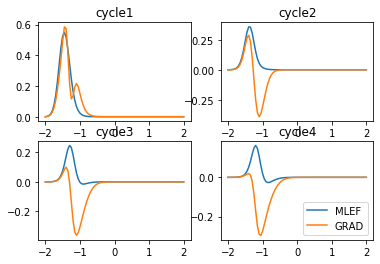

[]
[]


In [29]:
### assimilation
def set_r(nx, sigma):
    rmat = np.diag(np.ones(nx) / sigma)
    rinv = rmat.transpose() @ rmat
    return rmat, rinv

global zetak
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

lag = 8
## MLEF
##initialize
zetak = []
init_ens(lag)
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
rmat, rinv = set_r(N_obs, obs_s)
htype = {"operator":obstype[obs_opt],"perturbation":"mlef"}
trPa = []
Jmin_m = []
Chi_m = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = uef - uf[k].reshape(-1,1)#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        print("cycle"+str(k_obs))
        mask = np.random.choice(jmax,obsmiss,replace=False)
        if(k_obs==3):
            ua[k], pa = analysis(uef,uf[k],yo[k_obs],rmat,rinv,htype,disp=True,\
                             save_hist=True, save_dh=True)
            ue = ua[k,:, None] + pa
        else:
            ua[k], pa = analysis(uef,uf[k],yo[k_obs],rmat,rinv,htype,\
                             save_hist=False, save_dh=False)
            ue = ua[k,:, None] + pa
        trPa.append(np.mean(np.diag(pa@pa.T)))
    else:
        ua[k] = uf[k]
        ue = uef[:,:]

rmsea = np.zeros(N_cycles)
for i in range(1,N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmsea[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmsea = np.sqrt(rmsea)

fig = plt.figure()
ax = []
for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax.append(fig.add_subplot(2, 2, i, title="cycle"+str(i)))
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="MLEF")


## GRAD
##initialize
zetak = []
init_ens(lag)
ua = np.zeros((fcst_length+1,jmax)) # analysis, control
uf = np.zeros((fcst_length+1,jmax)) # forecast, control
ue = np.zeros((jmax,mem)) # ensemble(analysis)
uef = np.zeros((jmax,mem)) # ensemble(forecast)
ua[0] = uc0[:]
uf[0] = uc0[:]
ue = ue0[:,:]
htype = {"operator":obstype[obs_opt],"perturbation":"grad"}
trPa = []
Jmin_g = []
Chi_g = []
P0 = sqrtPa0@sqrtPa0.T
trPa.append(np.mean(np.diag(P0)))
for k in range(1,fcst_length+1):
    # forecast
    uf[k] = step(ua[k-1], dx, dt, nu)
    for imem in range(mem):
        uef[:,imem] = step(ue[:,imem], dx, dt, nu)
    sqrtPf = np.zeros(uef.shape)
    sqrtPf = (uef - uf[k].reshape(-1,1))#/np.sqrt(mem-1)
    #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
    if(k%N_steps==0):
    # analysis
        k_obs = int(k/N_steps) - 1
        print("cycle"+str(k_obs))
        mask = np.random.choice(jmax,obsmiss,replace=False)
        if(k_obs==3):
            ua[k], pa = analysis(uef,uf[k],yo[k_obs],rmat,rinv,htype,disp=True,\
                             save_hist=True, save_dh=True)
            ue = ua[k,:, None] + pa
        else:
            ua[k], pa = analysis(uef,uf[k],yo[k_obs],rmat,rinv,htype,\
                             save_hist=False, save_dh=False)
            ue = ua[k,:, None] + pa
        trPa.append(np.mean(np.diag(pa@pa.T)))
    else:
        ua[k] = uf[k]
        ue = uef[:,:]
rmseg = np.zeros(N_cycles)
for i in range(1,N_cycles+1):
    ind_a = i*N_steps
    ind_t = i*N_steps
    rmseg[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
rmseg = np.sqrt(rmseg)

for i in range(1,5):
    ind_a = i*N_steps
    ind_t = i*N_steps
    ax[i-1].plot(x, ua[ind_a]-ut[ind_t],label="GRAD")
    
print("rmse MLEF")
print(rmsea)

print("rmse GRAD")
print(rmseg)

plt.legend()
plt.savefig("anl_err_"+obstype[obs_opt]+".png")
plt.show()

print(Chi_m)
print(Chi_g)
#print("error covariance")
#print(trPa)

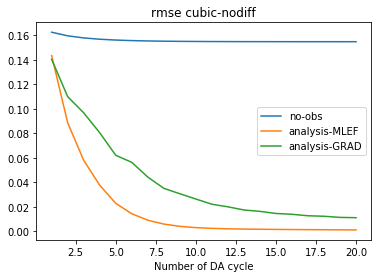

In [30]:
DAcycle = np.arange(1,N_cycles+1)
plt.plot(DAcycle,rmsen[1:],label="no-obs")
plt.plot(DAcycle,rmsea,label="analysis-MLEF")
plt.plot(DAcycle,rmseg,label="analysis-GRAD")
#plt.plot(DAcycle,rmsef,label="background")
#plt.plot(DAcycle,trPa[1:],label="trPa")
plt.xlabel("Number of DA cycle")
plt.title("rmse "+obstype[obs_opt])
plt.legend()
plt.savefig("rmse-BURGERS-mlef-grad_"+obstype[obs_opt]+".png")
plt.show()

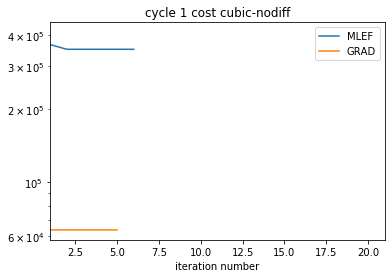

In [31]:
j_m = np.loadtxt("jh_"+obstype[obs_opt]+"_mlef.txt")
j_g = np.loadtxt("jh_"+obstype[obs_opt]+"_grad.txt")
plt.plot(j_m,label="MLEF")
plt.plot(j_g,label="GRAD")
plt.yscale("log")
plt.xlim([1,21])
plt.xlabel("iteration number")
plt.title("cycle 1 cost "+obstype[obs_opt])
plt.legend()
plt.show()

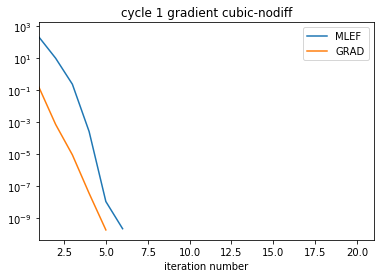

In [32]:
j_m = np.loadtxt("gh_"+obstype[obs_opt]+"_mlef.txt")
j_g = np.loadtxt("gh_"+obstype[obs_opt]+"_grad.txt")
plt.plot(j_m,label="MLEF")
plt.plot(j_g,label="GRAD")
plt.yscale("log")
plt.xlim([1,21])
plt.xlabel("iteration number")
plt.title("cycle 1 gradient "+obstype[obs_opt])
plt.legend()
plt.show()

In [14]:
### assimilation
fcst_length = N_cycles * N_steps
obsmiss = jmax - N_obs
print("fcst length = {}, incr_dt = {}sec., obs miss = {}".format(fcst_length, incr_dt, obsmiss))

SPRD = []
MRMSE = []
GRMSE = []
for lag in [20,15,10,5]:
    print("lag = {}".format(lag))

## MLEF
##initialize
    init_ens(lag)
    SPRD.append(ispr)
    ua = np.zeros((fcst_length+1,jmax)) # analysis, control
    uf = np.zeros((fcst_length+1,jmax)) # forecast, control
    ue = np.zeros((jmax,mem)) # ensemble(analysis)
    uef = np.zeros((jmax,mem)) # ensemble(forecast)
    ua[0] = uc0[:]
    uf[0] = uc0[:]
    ue = ue0[:,:]
    trPa = []
    Jmin_m = []
    Chi_m = []
    P0 = sqrtPa0@sqrtPa0.T
    trPa.append(np.mean(np.diag(P0)))
    for k in range(1,fcst_length+1):
        # forecast
        uf[k] = step(ua[k-1], dx, dt, nu)
        for imem in range(mem):
            uef[:,imem] = step(ue[:,imem], dx, dt, nu)
        sqrtPf = np.zeros(uef.shape)
        sqrtPf = uef - uf[k].reshape(-1,1)#/np.sqrt(mem-1)
        #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
        if(k%N_steps==0):
        # analysis
            k_obs = int(k/N_steps) - 1
            print("cycle"+str(k_obs))
            mask = np.random.choice(jmax,obsmiss,replace=False)
            (ue, Pa, ua[k], jmin, chi2) = Analysis(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
            trPa.append(np.mean(np.diag(Pa)))
            Jmin_m.append(jmin)
            Chi_m.append(chi2)
        else:
            ua[k] = uf[k]
            ue = uef[:,:]

    rmsea = np.zeros(N_cycles)
    for i in range(1,N_cycles+1):
        ind_a = i*N_steps
        ind_t = i*N_steps
        rmsea[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
    rmsea = np.sqrt(rmsea)

    MRMSE.append(rmsea)
    
## GRAD
##initialize
    init_ens(lag)
    ua = np.zeros((fcst_length+1,jmax)) # analysis, control
    uf = np.zeros((fcst_length+1,jmax)) # forecast, control
    ue = np.zeros((jmax,mem)) # ensemble(analysis)
    uef = np.zeros((jmax,mem)) # ensemble(forecast)
    ua[0] = uc0[:]
    uf[0] = uc0[:]
    ue = ue0[:,:]
    trPa = []
    Jmin_g = []
    Chi_g = []
    P0 = sqrtPa0@sqrtPa0.T
    trPa.append(np.mean(np.diag(P0)))
    for k in range(1,fcst_length+1):
        # forecast
        uf[k] = step(ua[k-1], dx, dt, nu)
        for imem in range(mem):
            uef[:,imem] = step(ue[:,imem], dx, dt, nu)
        sqrtPf = np.zeros(uef.shape)
        sqrtPf = (uef - uf[k].reshape(-1,1))#/np.sqrt(mem-1)
        #sqrtPf = (uef - uf[k].reshape(-1,1))/np.sqrt(2.0*(mem-1))
        if(k%N_steps==0):
        # analysis
            k_obs = int(k/N_steps) - 1
            print("cycle"+str(k_obs))
            mask = np.random.choice(jmax,obsmiss,replace=False)
            (ue, Pa, ua[k], jmin, chi2) = Analysis_G(uf[k], uef, sqrtPf, yo[k_obs], obs_s, mem, jmax, obsmiss, mask, obs_opt)
            trPa.append(np.mean(np.diag(Pa)))
            Jmin_g.append(jmin)
            Chi_g.append(chi2)
        else:
            ua[k] = uf[k]
            ue = uef[:,:]
    rmseg = np.zeros(N_cycles)
    for i in range(1,N_cycles+1):
        ind_a = i*N_steps
        ind_t = i*N_steps
        rmseg[i-1] = np.mean((ua[ind_a]-ut[ind_t])**2)
    rmseg = np.sqrt(rmseg)

    GRMSE.append(rmseg)
    
print(MRMSE)
print(GRMSE)
#print("error covariance")
#print(trPa)

fcst length = 400, incr_dt = 900.0sec., obs miss = 0
lag = 20
initial ensemble spread = 0.039251759990821804
ensemble initialized
cycle0
4.9e-07
70.41254401546396
         Current function value: 1648542.305841
         Iterations: 3
         Function evaluations: 111
         Gradient evaluations: 99
cycle1
4.9e-07
10273.177146617569
         Current function value: 615110.913319
         Iterations: 7
         Function evaluations: 51
         Gradient evaluations: 40
cycle2
4.9e-07
91794.00141690233
         Current function value: 293553.176436
         Iterations: 6
         Function evaluations: 52
         Gradient evaluations: 40
cycle3
4.9e-07
778232.3289179038
         Current function value: 67593.239294
         Iterations: 6
         Function evaluations: 65
         Gradient evaluations: 53
cycle4
4.9e-07
4235684.045405557
Optimization terminated successfully.
         Current function value: 19376.254047
         Iterations: 10
         Function evaluations: 13
         

cycle19
4.9e-07
104855089352.90665
Optimization terminated successfully.
         Current function value: 10720.826583
         Iterations: 6
         Function evaluations: 8
         Gradient evaluations: 8
lag = 15
initial ensemble spread = 0.022794892700595613
ensemble initialized
cycle0
4.9e-07
53.568038029141384
         Current function value: 1815138.121424
         Iterations: 3
         Function evaluations: 71
         Gradient evaluations: 59
cycle1
4.9e-07
124018.62392458058
         Current function value: 852947.794986
         Iterations: 7
         Function evaluations: 57
         Gradient evaluations: 45
cycle2
4.9e-07
1591130.2717572434
Optimization terminated successfully.
         Current function value: 362202.299460
         Iterations: 7
         Function evaluations: 11
         Gradient evaluations: 11
cycle3
4.9e-07
14448769.179301653
         Current function value: 74132.617493
         Iterations: 4
         Function evaluations: 61
         Gradient evalu

244669092163.15714
Optimization terminated successfully.
         Current function value: 4855.774168
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
cycle19
4.9e-07
318063186677.0638
Optimization terminated successfully.
         Current function value: 4231.338950
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
lag = 10
initial ensemble spread = 0.01038567344451425
ensemble initialized
cycle0
4.9e-07
125.5006711823505
         Current function value: 826461.279362
         Iterations: 3
         Function evaluations: 74
         Gradient evaluations: 62
cycle1
4.9e-07
1046495.4666124441
         Current function value: 439584.015206
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 48
cycle2
4.9e-07
9020551.019949744
Optimization terminated successfully.
         Current function value: 330675.760781
         Iterations: 7
         Function evaluations: 11
        

         Current function value: 608.904792
         Iterations: 4
         Function evaluations: 85
         Gradient evaluations: 71
cycle18
4.9e-07
185279727045.0222
         Current function value: 595.154840
         Iterations: 4
         Function evaluations: 103
         Gradient evaluations: 89
cycle19
4.9e-07
297942597531.53033
Optimization terminated successfully.
         Current function value: 493.029555
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6
lag = 5
initial ensemble spread = 0.002637685023391275
ensemble initialized
cycle0
4.9e-07
205.27734113924754
         Current function value: 938512.141019
         Iterations: 4
         Function evaluations: 74
         Gradient evaluations: 62
cycle1
4.9e-07
19054799.768793806
         Current function value: 758679.535529
         Iterations: 7
         Function evaluations: 59
         Gradient evaluations: 47
cycle2
4.9e-07
160228128.7395594
         Current function value: 834

         Current function value: 35480.840924
         Iterations: 3
         Function evaluations: 39
         Gradient evaluations: 27
cycle19
4.9e-07
1339230563688.9055
         Current function value: 94251.823463
         Iterations: 5
         Function evaluations: 81
         Gradient evaluations: 69
[array([0.14803429, 0.06722614, 0.03653936, 0.02272035, 0.01642751,
       0.01338393, 0.01135407, 0.0097897 , 0.00851245, 0.00746089,
       0.00660604, 0.00590783, 0.00529004, 0.00479209, 0.00436923,
       0.00400959, 0.00370178, 0.00342686, 0.00319507, 0.00298491]), array([0.1300482 , 0.06431772, 0.03764638, 0.02544395, 0.01964576,
       0.01615906, 0.01357448, 0.01377077, 0.01180953, 0.01179724,
       0.01033616, 0.01032014, 0.00919803, 0.00920744, 0.00836213,
       0.00840552, 0.00773956, 0.00715978, 0.00666545, 0.00622758]), array([0.15908101, 0.08872859, 0.05694301, 0.04026802, 0.02752458,
       0.02114001, 0.01458569, 0.01162546, 0.00819967, 0.00684985,
       0.0058269

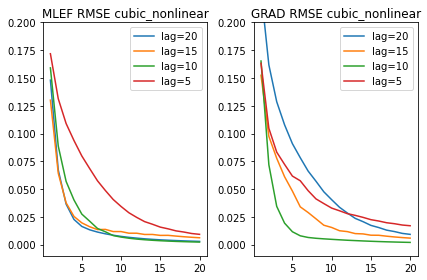

In [15]:
DAcycle = np.arange(1,N_cycles+1)
Lag = [20,15,10,5]
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1,title="MLEF RMSE "+obstype[obs_opt])
for i in range(len(Lag)):
    ax1.plot(DAcycle,MRMSE[i],label="lag="+str(Lag[i]))
plt.ylim([-0.01,0.2])
plt.legend()

ax2 = fig.add_subplot(1,2,2,title="GRAD RMSE "+obstype[obs_opt])
for i in range(len(Lag)):
    ax2.plot(DAcycle,GRMSE[i],label="lag="+str(Lag[i]))
plt.legend()
plt.ylim([-0.01,0.2])
fig.tight_layout()
plt.savefig("lag-RMSE_"+obstype[obs_opt]+".png")
plt.show()

[0.01928661 0.02139174 0.0235766  0.05006014]
[0.05958575 0.03221603 0.01818288 0.04645096]


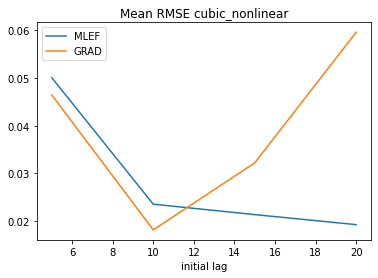

In [16]:
data = np.array(MRMSE)
rmse_m = np.mean(data,axis=1)
print(rmse_m)
data = np.array(GRMSE)
rmse_g = np.mean(data,axis=1)
print(rmse_g)
plt.plot(Lag,rmse_m,label="MLEF")
plt.plot(Lag,rmse_g,label="GRAD")
#plt.xscale('log')
#plt.xlabel('initial spread')
plt.xlabel('initial lag')
plt.legend()
plt.title('Mean RMSE '+obstype[obs_opt])
plt.savefig("lag-meanRMSE_"+obstype[obs_opt]+".png")
plt.show()